# The Optimal Wedding (with Pyomo)

Congratulations, this is probably going to be the happiest day in your life! If there weren't those guests you have to tactfully disseminate over the wedding tables... In this notebook, **we'll learn how to write down and solve a mathematical model for an optimization under constraints using the open-source Pyomo modelling language and the open-source CBC solver**.

## Getting started

To run this notebook, you need python (the code has been tested with version 3.7) as well as the packages listed in the `requirements.txt` file, and in particular [pyomo](https://www.pyomo.org/). Furthermore, to solve the seating arrangement model, you need to install the "COIN-OR CBC" optimization solver, for example as explained [here](https://calliope.readthedocs.io/en/stable/user/installation.html):

`conda install -c conda-forge coincbc`

In [1]:
import math
import random
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyomo.environ import AbstractModel, ConcreteModel, Set, Var, Param, Binary, Constraint, Objective, minimize, SolverFactory, value


plt.rcParams['figure.figsize'] = [10, 10] 
plt.rc('xtick', labelsize=14)  # fontsize of the x tick labels
plt.rc('ytick', labelsize=14)  # fontsize of the y tick labels
plt.rc('axes', titlesize=18)  # fontsize of the title
plt.rc('figure', titlesize=20)  # fontsize of the title
plt.rc('axes', labelsize=15)  # fontsize of the axes labels
plt.rc('legend', fontsize=15)  # fontsize of the axes labels

%matplotlib inline

## The Seating Arrangement Problem

We want to arrange how the guests to a wedding are seated at tables. We have a list of $N$ guests, and we have $M$ tables, possibly associated to a different number of seats $n_1$ (for the first table), ..., to $n_M$ (for the $M$-th table). Of course, in order to find a solution, we make sure we have enough seats :

<center> $n_1 + \dots + n_M \geq N$  </center>


In [2]:
table_list = pd.read_csv("data/TableList.csv", index_col=0)
tables = table_list.index
table_capacity_dict = table_list["Number of Seats"].to_dict()
display(table_list)
print(f"Number of seats: {table_list['Number of Seats'].sum()}")
N = len(table_list)

Number of Seats
Table Name                 
Avocado                   4
Banana                    4
Coconut                   4
Dates                     4

Number of seats: 16


Each guest is characterized by two properties:

- his/her "**corona index**", which represents her opinion regarding the answer to the Corona pandemics, vaccination etc... It's a continuous score ranging from -5 ("Corona has been invented by Bill Gates to inject us a chip and control our mind") to +5 ("Can't get enough of this mRNA stuff, and I'm certainly not going to leave my quaranteen before I got my 3rd shot of this delicious Pfizer jab!")
- his/her **gender**. For simplicity, here we assume only two genders: female=1, male=0.

In [3]:
guest_list = pd.read_csv("data/GuestList.csv", index_col=0)
guests = guest_list.index.to_list()
gender_dict = guest_list["Gender"].to_dict()
N = len(guest_list)
print(f"Number of guests: {N}")

Number of guests: 16


In [4]:
guest_list

Corona Index  Gender
Full Name                               
Louis Benefici             -0.49       1
Marion Brandon              4.33       1
Saffron Cade                4.03       0
Sandrine Flippet            4.91       1
Corin Gillian               4.85       1
Barbara Jewell             -3.00       1
Julius Krazinski           -4.03       0
Samantha Krazinski         -3.88       1
Bria Lakhanpal              2.95       1
Lucius Motti               -4.98       0
Hilbert Nguyen             -1.58       0
Sandra Nguyen              -1.24       1
Lovel Praji                 0.23       0
Claren Serence             -2.36       0
Guido van Rossum            0.00       0
Lorena Vindi               -4.86       0

From the corona index, we can actually compute a **corona distance** between two guests, measuring how much their opinion regarding corona differ:

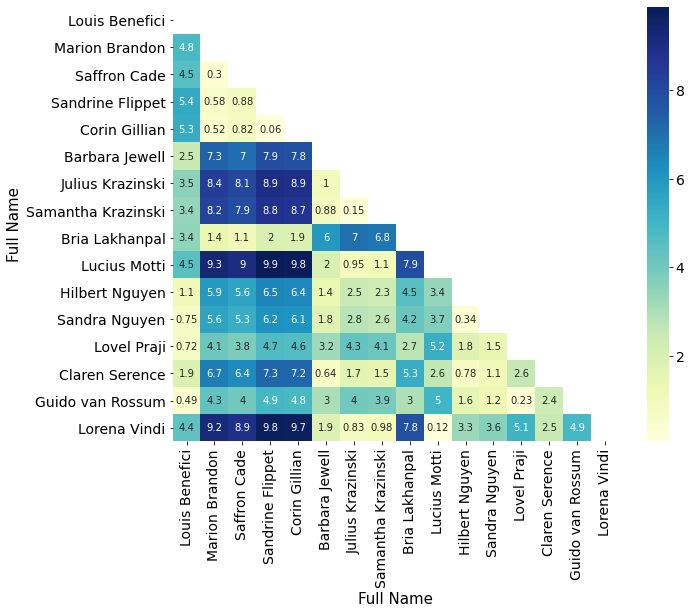

In [5]:
corona_distance_matrix = pd.DataFrame(index=guest_list.index, columns=guest_list.index)
corona_distance_dict = {}
for guest_1 in corona_distance_matrix.index:
    for guest_2 in corona_distance_matrix.columns:
        corona_distance = abs(guest_list.loc[guest_1, "Corona Index"] - guest_list.loc[guest_2, "Corona Index"])
        corona_distance_matrix.loc[guest_1, guest_2] = corona_distance
        corona_distance_dict[(guest_1, guest_2)] = corona_distance
corona_distance_matrix = corona_distance_matrix.astype(float)

# Display the corona-distance matrix as a heat map
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corona_distance_matrix, 
            annot=True, 
            mask=np.triu(np.triu(np.ones(corona_distance_matrix.shape)), -1), 
            cmap="YlGnBu",
            ax=ax)
plt.show()
ax.figure.tight_layout()
fig.savefig("corona_distance.png")

Since the distance between guest A and guest B is the same as between B and A, and the distance from A to A is zero, we display only one half of the matrix. The darker the cell, the more the opinions of people differ.

How do we want to arrange the seating of our guests ? We want to make our guests maximally happy. What's the secret of happiness? Ensuring they sit together with people having roughly the same opinion as them. In other words, **we want an arrangement that minimizes, on each table, the total corona distance**. You don't want Sandrine Flippet (score: +4.91) and Lucius Motti (score:-4.98) seating at the same table!

There seems to be a very simple of way achieving that: just sort the people by increasing corona score, and start filling up the tables according to this order:

In [6]:
guests_sorted_by_corona_score = guest_list.sort_values(by="Corona Index")
guests_sorted_by_corona_score["table"] = np.nan

guest_idx = 0
table_idx = 0
table_occupancy = 0
while guest_idx < N:
    guest = guests_sorted_by_corona_score.index[guest_idx]
    table = table_list.index[table_idx]
    if table_occupancy < table_list.loc[table, "Number of Seats"]:
        guests_sorted_by_corona_score.loc[guest, "table"] = table
        table_occupancy += 1
        guest_idx += 1
    else:
        table_idx += 1
        table_occupancy = 0

display(guests_sorted_by_corona_score)

Corona Index  Gender    table
Full Name                                        
Lucius Motti               -4.98       0  Avocado
Lorena Vindi               -4.86       0  Avocado
Julius Krazinski           -4.03       0  Avocado
Samantha Krazinski         -3.88       1  Avocado
Barbara Jewell             -3.00       1   Banana
Claren Serence             -2.36       0   Banana
Hilbert Nguyen             -1.58       0   Banana
Sandra Nguyen              -1.24       1   Banana
Louis Benefici             -0.49       1  Coconut
Guido van Rossum            0.00       0  Coconut
Lovel Praji                 0.23       0  Coconut
Bria Lakhanpal              2.95       1  Coconut
Saffron Cade                4.03       0    Dates
Marion Brandon              4.33       1    Dates
Corin Gillian               4.85       1    Dates
Sandrine Flippet            4.91       1    Dates

So far, so good. But what if we have now additional constraints ?

## Introducing new constraints

Let's do it a bit more complicated: assume now that on top of having people with close opinions sitting together, we want to achieve a reasonable gender mix at each table. For that, we require that **there should be at least one male and one female per table.**

In [7]:
min_females_per_table = 1
min_males_per_table = 1

And on top of that, let us assume that **Julius Krazinski and Samantha Krazinski (who used to be a couple long time ago) simply HATE each other.** You can't help it, but if you invite only one of them, the other one will be terribly offended. And believe me, if they sit at the same table, the wedding will be a NIGHTMARE.

How can we solve such a problem ?

## First solution: brute force

One way to tacke this problem is to:
- iterate through all the possible seating arrangements
- for each arrangement, check if there is at least one male and one female on each table
- check that the Krazinskis are not at the same table
- if the arrangement fulfills these conditions, compute the total corona distance per table and sum it over all tables
- compare it to the best one we've seen so far, and save this solution as our best one so far

But how many ways are there to arrange $N$ guests at $M$ tables of capacity $n_1, \dots n_m$ ?

If we line up all the chairs, beginning with those which belongs to the first table, then the second table etc., we have $N$ different possibilities for the first one, $N-1$ for the second one etc. : these are $N!$ (N factorial) combinations. However, within a table, the order of guests does not matter, which is why we have to divide, for each table, by $n_m!$, where $n_m$ is the capacity of table $m$. Altogether, we have

<center> $\frac{N!}{n_1! \dots n_M!}$ </center>

distinct possibilities.

In [8]:
n_seating_arrangements = math.factorial(N)
print(f"There a {n_seating_arrangements / 1e9:.2f} billion way to seat {N} guests on {table_list['Number of Seats'].sum()} chairs.")
for n_seats in table_list["Number of Seats"]:
    n_seating_arrangements = n_seating_arrangements / math.factorial(n_seats)
print(f"It corresponds to {n_seating_arrangements / 1e6:.2f} million distinct table arrangements.")

There a 20922.79 billion way to seat 16 guests on 16 chairs.
It corresponds to 63.06 million distinct table arrangements.


How long does it take to check if a solution is valid and, if yes, compute its total corona distance ? For that, we define a function which ingests a list of 16 guest names, with the convention that the first $n_1$ guests are seated on the 1st table, the next $n_2$ on the 2nd table, etc. We check the different constraints and, if they are all fulfilled, we compute the total corona distance.

In [9]:
def check_if_valid(seating_arrangement: List[str]):
    valid_solution = False

    guests_by_table = seat_guest_at_tables(seating_arrangement)

    total_corona_distance = 0
    for table in tables:
        guests_on_this_table = guests_by_table[table]
        table_capacity = table_capacity_dict[table]

        # check min number of males
        n_males = sum([gender_dict[guest] for guest in guests_on_this_table])
        if n_males < 1:
            valid_solution = False
            return valid_solution, total_corona_distance

        # check min number of females
        n_females = table_capacity_dict[table] - n_males
        if n_females < 1:
            valid_solution = False
            return valid_solution, total_corona_distance

        # check Krazinskis exclusion principle
        if ('Julius Krazinski' in guests_on_this_table) and ('Samantha Krazinski' in guests_on_this_table):
            valid_solution = False
            return valid_solution, total_corona_distance

        # if all checks have passed: the solution is valid !
        valid_solution = True
            
        # compute total corona distance
        distance_by_table = 0
        for index_1 in range(table_capacity_dict[table]):
            for index_2 in range(index_1, table_capacity):
                distance_by_table += corona_distance_dict[guests_on_this_table[index_1],
                                                          guests_on_this_table[index_2]]

        total_corona_distance += distance_by_table

    return valid_solution, total_corona_distance


def seat_guest_at_tables(seating_arrangement: List[str]):
    guests_by_table = {}
    index_start = 0
    for table in table_list.index:
        index_end = index_start + table_capacity_dict[table]
        guests_by_table[table] = seating_arrangement[index_start:index_end]
        index_start = index_end
    return guests_by_table

Let's check if an arbitrary seating arrangement is valid and compute its total corona distance:

In [10]:
seating_arrangement = random.sample(guests, k=N)  # randomly shuffle the guest list
is_valid, total_corona_distance = check_if_valid(seating_arrangement)
seating_arrangement_by_table = seat_guest_at_tables(seating_arrangement)
print(f"SEATING ARRANGEMENT:")
for table, guests_by_table in seating_arrangement_by_table.items():
    print(f"{table}: {guests_by_table}")
print(f"> Is this arrangement a valid solution?: {is_valid}") 
print(f"> Total corona distance: {total_corona_distance:.0f}")

SEATING ARRANGEMENT:
Avocado: ['Sandrine Flippet', 'Hilbert Nguyen', 'Lucius Motti', 'Guido van Rossum']
Banana: ['Corin Gillian', 'Sandra Nguyen', 'Bria Lakhanpal', 'Samantha Krazinski']
Coconut: ['Marion Brandon', 'Lorena Vindi', 'Julius Krazinski', 'Louis Benefici']
Dates: ['Claren Serence', 'Lovel Praji', 'Saffron Cade', 'Barbara Jewell']
> Is this arrangement a valid solution?: False
> Total corona distance: 31


How long does it take to evaluate, let's say 10,000 such arrangements ?

In [11]:
n_samples = 10000
tic = pd.Timestamp.now()
for k in range(n_samples):
    seating_arrangement = random.sample(guests, k=N)
    check_if_valid(seating_arrangement)
toc = pd.Timestamp.now()
duration = toc - tic
ms_per_sample = duration / pd.Timedelta(milliseconds=1) / n_samples
print(f"{ms_per_sample:.3f} ms/arrangement")

duration_all_arrangements = math.factorial(N) * ms_per_sample  # in ms
duration_all_distinct_seating_arrangements = n_seating_arrangements * ms_per_sample  # in ms

print(f"> Estimated duration to check all (redundant) table arrangements: {duration_all_arrangements / 1000 / 3600 / 24:.2} days.")
print(f"> Estimated duration to check all distinct table arrangements: {duration_all_distinct_seating_arrangements / 1000 :.5} seconds.")

0.025 ms/arrangement
> Estimated duration to check all (redundant) table arrangements: 6.1e+03 days.
> Estimated duration to check all distinct table arrangements: 1593.1 seconds.


## Express it as an optimization problem

Alternatively, you can see this problem as a typical example of **mathematical optimization under constraints**. We can formulate it in this way:

Find a "seating arrangement" which minimizes the sum of the corona distances on each table, subject to:
- there is a minimal share of females at each table
- there is a minimal share of males at each table
- Julius Krazinski and Samantha Krazinski DON'T sit at the same table (no way!)

What is a seating arrangement ? It's a mapping of guests onto tables where 
- each guest is assigned to one single table
- the number of guests assigned to each table does not exceed its capacity (number of seats)

We will formalize this by turning this conditions into mathematical equations. An optimization problem (sometimes called a Program) is expressed in terms of :

- **optimization variables**: these are the "decision" variables we want to find values for. For example, we will define of binary variables of the form $x_{g,t}$ where $x_{g,t}=1$ means that guest $g$ sits at table $t$, and $x_{g,t}=0$ the opposite. A **solution** of the optimization problem is a set of values where each of these variables is defined.

- **parameters**: these are *given* numbers which specify the problem. They are known in advance, for example: the corona distance $d_{i,j}$ between guest $i$ and guest $j$ or the capacity $n_t$ of table $t$.

- **constraints**: these are the equations any solution must fulfill. For example, *the number of guests seating at table $t$ must not exceed the capacity of table $T$"* translates into: $\sum_g x_{g,T} \leq n_T$ (the sum of the binary variables "guest g sits at table T" must be smaller or equal than its capacity $n_T$"

- and an **objective function**: this is the quantity we want to optimize. Here, for example, we are interested in minimizing the sum of the distance between each pair of guests sitting at a table, summed over all tables:


<center> $D = \sum \limits _\mathrm{t~in~tables}  \sum \limits _\mathrm{i~in~guests} \sum \limits _\mathrm{j~in~guests} z_{i,j,t} d_{i,j}$ </center>


where we have introduced a new (optimization) variable $z_{i,j,t}$ which is equal to 1 only if guest $i$ AND guest $j$ sit at table $t$.

Additionally, note that we have made use of **sets** to index our variables, parameters and constraints on: a set of guests and a set of tables.

**Sets, variables, parameters, constraints and an objective function are the ingredients of an optimization model**.

## Write it down using Pyomo

Let's now write these equations. **How can we write maths in programming code ?** That's where **modelling languages**, such as **Pyomo**, come in. They offer a "language" to write equations and get it transformed into a form that can be solved by a **solver**, i.e. a **program capable of finding the set of variable values optimizing (=maximize or minimize) the objective function, subject to the constraints.**

We start by defining an empty model (here, we use a so-called "AbstractModel", but at this stage it's not relevant why).

In [12]:
model = AbstractModel()

### Sets

We start by defining the sets the other components of the model will be indexed on.

In [13]:
model.guests = Set()
model.guests.construct(guest_list.index)
print(f"> Set of Guests: {model.guests.data()}")

model.tables = Set()
model.tables.construct(table_list.index)
print(f"> Set of Tables: {model.tables.data()}")

> Set of Guests: ('Louis Benefici', 'Marion Brandon', 'Saffron Cade', 'Sandrine Flippet', 'Corin Gillian', 'Barbara Jewell', 'Julius Krazinski', 'Samantha Krazinski', 'Bria Lakhanpal', 'Lucius Motti', 'Hilbert Nguyen', 'Sandra Nguyen', 'Lovel Praji', 'Claren Serence', 'Guido van Rossum', 'Lorena Vindi')
> Set of Tables: ('Avocado', 'Banana', 'Coconut', 'Dates')


### Parameters

Now, we define the model parameters. Some parameters are scalars, such as the minimal number of males or females per table:

In [14]:
model.min_females_per_table = min_females_per_table
model.min_males_per_table = min_males_per_table

Parameters can be indexed on sets. For example, the table capacity is indexed on the table set, while the guest gender is indexed on the guest set:

In [15]:
model.table_capacity = Param(model.tables)
model.table_capacity.construct(table_list["Number of Seats"].to_dict())
model.table_capacity.display()

model.gender = Param(model.guests)
model.gender.construct(guest_list["Gender"].to_dict())

table_capacity : Size=4, Index=tables, Domain=Any, Default=None, Mutable=False
    Key     : Value
    Avocado :     4
     Banana :     4
    Coconut :     4
      Dates :     4


We can also index parameters on sets produced using the original ones. For example, the corona distance between two guests is a parameter indexed on all the pairs of guests, ie the cross product of the guest set with itsel.

In [16]:
model.corona_distance = Param(model.guests * model.guests)
model.corona_distance.construct(corona_distance_dict)
model.corona_distance.display()

corona_distance : Size=256, Index=corona_distance_index, Domain=Any, Default=None, Mutable=False
    Key                                          : Value
            ('Barbara Jewell', 'Barbara Jewell') :                 0.0
            ('Barbara Jewell', 'Bria Lakhanpal') :                5.95
            ('Barbara Jewell', 'Claren Serence') :  0.6400000000000001
             ('Barbara Jewell', 'Corin Gillian') :                7.85
          ('Barbara Jewell', 'Guido van Rossum') :                 3.0
            ('Barbara Jewell', 'Hilbert Nguyen') :                1.42
          ('Barbara Jewell', 'Julius Krazinski') :  1.0300000000000002
              ('Barbara Jewell', 'Lorena Vindi') :  1.8600000000000003
            ('Barbara Jewell', 'Louis Benefici') :                2.51
               ('Barbara Jewell', 'Lovel Praji') :                3.23
              ('Barbara Jewell', 'Lucius Motti') :  1.9800000000000004
            ('Barbara Jewell', 'Marion Brandon') :               

### Optimization (decision) variables

Next, we define the optimization variables, sometimes also called decision variables. To model our problem, we will define two sets of binary variables:

- First, we define a set of binary variables telling us whether or not **a given guest sits at a given table**
- Then, we define a set of binary variables telling us whether or not **two given guests sit at a given table**

These variables are indexed over the corresponding (products of) sets.

The values of the variables `guest_seats_at[guest, table]` define a seat arrangement: they tell us who sits where.
Why do we need the second set of variables ? Hold on, this will become clear when we will define the objective function.

In [17]:
model.guest_seats_at = Var(model.guests * model.tables, domain=Binary)
model.two_guests_seat_at = Var(model.guests * model.guests * model.tables, domain=Binary)

### Constraints

**Constraints are (in-)equations involving variables and parameters.** For the type of problem we are looking at, we want to stick to **linear constraints**. It means that our constraints must be linear equations of the variables (the parameters being the coefficients of these equations). The reason for that is that there exists very powerful algorithms, such as the Simplex algorithm, to solve linear optimization models. The problem we are solving involves linear equations, it is hence a Linear Program. However, the variables we are looking at are binary, which is an extreme case of so-called "integer variables". For this reason, **such a problem is called a Mixed-Integer Linear Program (MILP).** There also exists clever algorithms to solve them, such as the Branch-and-Cut algorithm, which is implemented by the CBC (guess what BC stands for !) solver we use here. But in general, they are harder to solve than purely linear programs with continuous variables.

In Pyomo, we implement constraints by adding `Constraint` objects defined by a function (the "rule"). Constraints can be also indexed over a set. It allows us to conveniently define a bunch of equations at once. For example, this is how the constraint *Each guest must sit at exactly one table* translates:

In [18]:
def one_table_per_guest(model, guest):
    return sum(model.guest_seats_at[guest, table] for table in model.tables) == 1
model.one_table_per_guest = Constraint(model.guests, rule=one_table_per_guest)

Similarly, *the number of guests seated at a given table may not exceed its capacity*:

In [19]:
def max_table_occupancy(model, table):
    return sum(model.guest_seats_at[guest, table] for guest in model.guests) <= model.table_capacity[table]
model.max_table_occupancy = Constraint(model.tables, rule=max_table_occupancy)

The two constraints above define the purpose of the variable `guest_seats_at`

Our constraint on the minial share of each gender per table must be casted into two constraints:

In [20]:
def min_female_share_rule(model, table):
    n_females_at_table = sum(model.guest_seats_at[guest, table] * model.gender[guest] for guest in model.guests)
    return n_females_at_table >= model.min_females_per_table


def min_male_share_rule(model, table):
    n_females_at_table = sum(model.guest_seats_at[guest, table] * model.gender[guest] for guest in model.guests)
    n_males_at_table = model.table_capacity[table] - n_females_at_table
    return n_males_at_table >= model.min_males_per_table


model.min_female_share_constraint = Constraint(model.tables, rule=min_female_share_rule)
model.min_male_share_constraint = Constraint(model.tables, rule=min_male_share_rule)

(Note that due to the fact that females are encoded with 1 and males with 0, the constraints look slightly different.)

And now comes the tricky one: so far, we haven't set constraints to define the variable `two_guests_seat_at`. Trivially, one could link it to the variable `guest_seat_at` in following way:

`two_guests_seat_at[g1,g2,t] == guest_seat_at[g1,t] * guest_seat_at[g2,t]`

However, **this is not a linear constraint, as it involves a product of two variables.** Fortunately, since we are dealing here with binary variables, there is a "trick" to translate this constraint into three linear constraints:

`two_guests_seat_at[g1,g2,t] <= two_guests_seat_at[g1,t]` (C1)

`two_guests_seat_at[g1,g2,t] <= two_guests_seat_at[g1,t] * two_guests_seat_at[g2,t]` (C2)

`two_guests_seat_at[g1,g2,t] >= two_guests_seat_at[g1,t] + two_guests_seat_at[g2,t] - 1` (C3)

You can convince yourself by writing down the 2²=4 different combinations of values for `two_guests_seat_at[g1,t]` and `two_guests_seat_at[g2,t]` that the three linear constraints effectively ensure that `two_guests_seat_at[g1,g2,t] == guest_seat_at[g1,t] * guest_seat_at[g2,t]`. Note that this trick only works because the variables are binary, it wouldn't work with continuous variables.


In [21]:
def two_guests_seat_at_C1(model, guest_1, guest_2, table):
    return model.two_guests_seat_at[(guest_1, guest_2, table)] <= model.guest_seats_at[(guest_1, table)]


def two_guests_seat_at_C2(model, guest_1, guest_2, table):
    return model.two_guests_seat_at[(guest_1, guest_2, table)] <= model.guest_seats_at[guest_2, table]


def two_guests_seat_at_C3(model, guest_1, guest_2, table):
    return model.two_guests_seat_at[(guest_1, guest_2, table)] >= model.guest_seats_at[guest_1, table] + model.guest_seats_at[guest_2, table] - 1


model.definition_two_guests_seat_at_C1 = Constraint(model.guests * model.guests * model.tables, rule=two_guests_seat_at_C1)
model.definition_two_guests_seat_at_C2 = Constraint(model.guests * model.guests * model.tables, rule=two_guests_seat_at_C2)
model.definition_two_guests_seat_at_C3 = Constraint(model.guests * model.guests * model.tables, rule=two_guests_seat_at_C3)

Eventually, we need to write down the "Krazinski exclusion principle", stating that Mr. and Mrs Krazinski may not seat at the same table. We do this by adding constraints indexed over the table set:

In [22]:
def no_more_than_one_krazinski_at_a_table(model, table):
    return model.guest_seats_at[("Samantha Krazinski", table)] + model.guest_seats_at[("Julius Krazinski", table)] <= 1

model.krazinski_exclusion_principle = Constraint(model.tables, rule=no_more_than_one_krazinski_at_a_table)

## Objective function

One ingredient is still missing to our model: the objective function we want to optimize. Here, we want to minimze the total corona distance on each table. We do that in two steps:
- First, for a given table, we define a function measuring the sum of the corona distances between all pairs of guests sitting at the same table (the factor 1/2 is to avoid counting the same two guests twice)
- Then we sum this distance over all the tables.

Since the total number of tables is given, it doesn't matter whether we minimize the average of the table distances or its sum.

Similarly to what we have done about the constraints, we pass the "rule" (= the equation) defining the objective function to the model, along with the direction of the optimization (minimize or maximize). 

In [23]:
def total_corona_distance_on_table(model, table):
    return 0.5 * sum(model.corona_distance[guest_1, guest_2] * model.two_guests_seat_at[(guest_1, guest_2, table)]
                     for guest_1 in model.guests
                     for guest_2 in model.guests)

def total_corona_distance(model):
    return sum(total_corona_distance_on_table(model, table) for table in model.tables)


model.CoronaDistance = Objective(rule=total_corona_distance, sense=minimize)

## Solving the model

Now, the stage is ready ! We have a well-defined model which we can pass to a solver. Pyomo supports "concrete" and "abstract" models. The distinction is not relevant here, but since we've been working with an abstract model, we need to "initialize" it before passing it to the solver.

Note that as we will see below, even for a small number of guests/tables, there are millions of possible seating arrangements. On a standard laptop, solving this model takes for example roughly 20 to 30 seconds.

In [24]:
model = model.create_instance()
solver = SolverFactory("cbc")
print("solve")
output = solver.solve(model, timelimit=120)
print(output.solver.termination_condition)
print(f"completion time: {output.solver.Time} s.")  # 16 guests -> 10 seconds

solve
optimal
completion time: 11.19642186164856 s.


In [25]:
print(f"Objective: {value(model.CoronaDistance):.2f}")

Objective: 29.18


We can now extract the optimized values of the variables from the model. In particular, we are interested in the seating arrangement defined by `model.guest_seats_at[guest, table]`:

In [26]:
guest_seats_at = model.guest_seats_at.extract_values()
guest_seats_at_df = pd.DataFrame(index=guest_list.index, columns=table_list.index)
for guest in guest_list.index:
    for table in table_list.index:
        guest_seats_at_df.loc[guest, table] = guest_seats_at[(guest, table)]

guest_seats_at = guest_seats_at_df.astype(float)
guest_seats_at = guest_seats_at.idxmax(axis=1)
guest_list["Table"] = guest_seats_at

We can check that:
- each guest is associated to a table and that each table hosts 4 guests
- he have at least one male and one female guest per table
- Samantha and Julius Krazinski do not sit at the same table (despite having relatively similar opinions on Corona)

In [27]:
print("Guests by table:")
display(guest_list.sort_values(by="Table"))

Guests by table:


Corona Index  Gender    Table
Full Name                                        
Barbara Jewell             -3.00       1  Avocado
Julius Krazinski           -4.03       0  Avocado
Lucius Motti               -4.98       0  Avocado
Lorena Vindi               -4.86       0  Avocado
Marion Brandon              4.33       1   Banana
Saffron Cade                4.03       0   Banana
Sandrine Flippet            4.91       1   Banana
Corin Gillian               4.85       1   Banana
Samantha Krazinski         -3.88       1  Coconut
Hilbert Nguyen             -1.58       0  Coconut
Sandra Nguyen              -1.24       1  Coconut
Claren Serence             -2.36       0  Coconut
Louis Benefici             -0.49       1    Dates
Bria Lakhanpal              2.95       1    Dates
Lovel Praji                 0.23       0    Dates
Guido van Rossum            0.00       0    Dates

By looking at the average and the standard deviation of the corona index on each table, we see that the distribution of corona index on each table is relatively "narrow": the algorithm tries to achieve the most homogeneous mix, while fulfilling the other constraints.

In [28]:
print("Averages")
display(guest_list.groupby("Table").mean())

print("Std deviation")
display(guest_list.groupby("Table").std())


Averages


Corona Index  Gender
Table                        
Avocado       -4.2175    0.25
Banana         4.5300    0.75
Coconut       -2.2650    0.50
Dates          0.6725    0.50

Std deviation


Corona Index   Gender
Table                         
Avocado      0.915000  0.50000
Banana       0.423005  0.50000
Coconut      1.174322  0.57735
Dates        1.547738  0.57735

**And how can we be sure that the solution is optimal ?** You can prove mathematically that the algorithm implemented by the solver returns an optimal solution. Apart from that, you can collect "anecdotal evidence" that the optimal solution is better than any valid solution you could generate:

In [32]:
optimal_arrangement = tuple(guest_list.sort_values(by="Table").index)
is_valid, best_corona_distance = check_if_valid(optimal_arrangement)
print(f"The optimal arrangement is a valid solution: {is_valid}")
print(f"Total corona distance of optimal arrangement: {best_corona_distance:.1f}")

The optimal arrangement is a valid solution: True
Total corona distance of optimal arrangement: 29.2


In [33]:
n_valid_arrangements = 10
k = 0
while k < n_valid_arrangements:
    seating_arrangement = random.sample(guests, k=N) 
    is_valid, total_corona_distance = check_if_valid(seating_arrangement)
    if is_valid:
        print(f"{total_corona_distance:.1f}")
        k += 1

93.8
97.9
88.9
115.4
65.9
86.0
111.7
116.0
104.9
109.2


Of course, it's not a proof, but it suggests that it's quite hard to beat the best solution !

## Conclusion

In this notebook, you have:

- seen **how to express a "real-life" (well...) problem as a mathematical optimization problem**, defining variables, parameters, constraints, sets and an objective function
- **translated it into python code using the Pyomo modelling language**,
- **solved the problem using the open-source solver COIN-OR CBC** and **extracted the solution** from the pyomo model.

### Further readings: 

- if you want to know more about the actual **algorithms and methods used to solve optimization problems**, you can look for example at this [course from Standford University](https://web.stanford.edu/group/sisl/k12/optimization/MO-unit1-pdfs/1.1optimization.pdf).
- **experiment further with Pyomo**, have a look at the [Pyomo Gallery on GitHub](https://github.com/Pyomo/PyomoGallery/wiki) or read the [book](https://www.springer.com/gp/book/9781489993250)
- Note that there exist also **other modelling frameworks for Python**, such as the [PuLP package for Mixed-Integer Linear Programs](https://github.com/coin-or/pulp).